In [122]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from io import open
from collections import Counter
from functools import partial
import unicodedata
import re
from torch.autograd import Variable
from gensim.models import KeyedVectors
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Process Data

In [205]:
RESERVED_TOKENS = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, '<UNK>': 3}
BATCH_SIZE = 32
SRC_MAX_SENTENCE_LEN = 20 
TARG_MAX_SENTENCE_LEN = 20
SRC_VOCAB_SIZE = 50000
TARG_VOCAB_SIZE = 5000
HIDDEN_SIZE = 300

In [206]:
def text2tokens(raw_text_fp): 
    """ Takes filepath to raw text and outputs a list of lists, each representing a sentence of words (tokens) """
    with open(raw_text_fp) as f:
        tokens_data = [line.lower().split() for line in f.readlines()]       
        tokens_data = [datum + ['<EOS>'] for datum in tokens_data]
    return tokens_data 

def load_word2vec(lang): 
    """ Loads pretrained vectors for a given language """
    filepath = "data/pretrained_word2vec/wiki.zh.vec".format(lang)
    word2vec = KeyedVectors.load_word2vec_format(filepath)
    return word2vec

def build_vocab(token_lists, max_vocab_size, word2vec): 
    """ Takes lists of tokens (representing sentences of words), max_vocab_size, word2vec model and returns: 
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
        Note that the vocab will comprise N=max_vocab_size-len(RESERVED_TOKENS) tokens that are in word2vec model 
    """
    num_vocab = max_vocab_size - len(RESERVED_TOKENS)
    all_tokens = [token for sublist in token_lists for token in sublist]
    token_counter = Counter(all_tokens)
    token_counter_filtered = Counter({token: token_counter[token] for token in token_counter if token in word2vec})
    vocab, count = zip(*token_counter_filtered.most_common(num_vocab))
    id2token = list(RESERVED_TOKENS.keys()) + list(vocab)
    token2id = dict(zip(id2token, range(max_vocab_size)))
    return token2id, id2token 

# def build_vocab(token_lists, max_vocab_size, word2vec): 
#     """ Takes lists of tokens (representing sentences of words), max_vocab_size, word2vec model and returns: 
#         - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
#         - token2id: dictionary where keys represent tokens and corresponding values represent their indices
#         Note that the vocab will comprise N=max_vocab_size-len(RESERVED_TOKENS) tokens that are in word2vec model 
#     """
#     all_tokens = [token for sublist in token_lists for token in sublist]
#     token_counter = Counter(all_tokens)
#     token_counter_filtered = Counter({token: token_counter[token] for token in token_counter if token in word2vec})
#     vocab, count = zip(*token_counter_filtered.most_common(max_vocab_size))
#     id2token = list(vocab)
#     token2id = dict(zip(vocab, range(len(RESERVED_TOKENS), len(RESERVED_TOKENS)+len(vocab))))
#     id2token = list(RESERVED_TOKENS.keys()) + id2token 
#     for t in RESERVED_TOKENS: 
#         token2id[t] = RESERVED_TOKENS[t]
#     return token2id, id2token 

def tokens2indices(tokens_data, token2id): 
    """ Takes tokenized data and token2id dictionary and returns indexed data """
    indices_data = [] 
    for datum in tokens_data: 
        indices_datum = [token2id[token] if token in token2id else RESERVED_TOKENS['<UNK>'] for token in datum ]
        indices_data.append(indices_datum)    
    return indices_data

def get_filepath(split, src_lang, targ_lang, lang_type): 
    """ Locates data filepath given data split type (train/dev/test), translation pairs (src_lang -> targ_lang), 
        and the language type (source or target)
    """
    folder_name = "data/iwslt-{}-{}/".format(src_lang, targ_lang)
    if lang_type == 'source': 
        file_name = "{}.tok.{}".format(split, src_lang)
    elif lang_type == 'target': 
        file_name = "{}.tok.{}".format(split, targ_lang)
    return folder_name + file_name 

def get_filepaths(src_lang, targ_lang): 
    """ Takes language names to be translated from and to (in_lang and out_lang respectively) as inputs, 
        returns a nested dictionary containing the filepaths for input/output data for train/dev/test sets  
    """
    fps = {} 
    for split in ['train', 'dev', 'test']: 
        fps[split] = {} 
        for lang_type in ['source', 'target']: 
            fps[split][lang_type] = {} 
            fps[split][lang_type]['filepath'] = get_filepath(split, src_lang, targ_lang, lang_type)
    return fps 

def process_data(src_lang, targ_lang, src_max_vocab_size, targ_max_vocab_size): 
    """ Takes source language and target language names and respective max vocab sizes as inputs 
        and returns as a nested dictionary containing: 
        - train_indices, val_indices, test_indices (as lists of source-target tuples)
        - train_tokens, val_tokens, test_tokens (as lists of source-target tuples)
        - source language's token2id and id2token 
        - target language's token2id and id2token
    """
    
    # get filepaths 
    data = get_filepaths(src_lang, targ_lang)
    
    # attach vocab sizes and word2vec models 
    data['train']['source']['max_vocab_size'] = src_max_vocab_size
    data['train']['target']['max_vocab_size'] = targ_max_vocab_size 
    data['train']['source']['word2vec'] = load_word2vec(src_lang) 
    data['train']['target']['word2vec'] = load_word2vec(targ_lang) 
    
    # loop through each file, read in text, convert to tokens, then to indices 
    for split in ['train', 'dev', 'test']: 
        for lang_type in ['source', 'target']: 
            
            # read in tokens 
            data[split][lang_type]['tokens'] = text2tokens(data[split][lang_type]['filepath'])
            
            # build vocab from training data
            if split == 'train': 
                data['train'][lang_type]['token2id'], data['train'][lang_type]['id2token'] = build_vocab(
                    token_lists = data['train'][lang_type]['tokens'], 
                    max_vocab_size = data['train'][lang_type]['max_vocab_size'], 
                    word2vec = data['train'][lang_type]['word2vec']) 
                
            # convert tokens to indices 
            data[split][lang_type]['indices'] = tokens2indices(
                data[split][lang_type]['tokens'], data['train'][lang_type]['token2id'])
            
    return data

In [207]:
def get_pretrained_emb(word2vec, token2id): 
    """ Given word2vec model and the vocab's token2id, extract pretrained word embeddings """
    pretrained_emb = np.zeros((len(token2id), 300)) 
    for token in token2id: 
        try: 
            pretrained_emb[token2id[token]] = word2vec[token]
        except: 
            pretrained_emb[token2id[token]] = np.random.normal(size=(300,))
    return torch.from_numpy(pretrained_emb.astype(np.float32)).to(device)

In [208]:
class TranslationDataset(Dataset): 
    """ 
    Class that represents a train/validation/test/dataset that's readable for Pytorch. 
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, src_indices, targ_indices, src_max_sentence_len, targ_max_sentence_len):
        """ 
        Initialize dataset by passing in a list of input indices and a list of output indices 
        """
        self.src_indices = src_indices
        self.targ_indices = targ_indices
        self.src_max_sentence_len = src_max_sentence_len
        self.targ_max_sentence_len = targ_max_sentence_len
        assert (len(self.src_indices) == len(self.targ_indices))
        
    def __len__(self): 
        return len(self.src_indices)
    
    def __getitem__(self, key): 
        """ 
        Triggered when dataset[i] is called, outputs lists of input and output indices, as well as their 
        respective lengths
        """
        src_idx = self.src_indices[key][:self.src_max_sentence_len]
        src_len = len(src_idx)
        targ_idx = self.targ_indices[key][:self.targ_max_sentence_len]
        targ_len = len(targ_idx)
        return [src_idx, targ_idx, src_len, targ_len]
    
def collate_func(src_max_sentence_len, targ_max_sentence_len, batch): 
    """ Customized function for DataLoader that dynamically pads the batch so that all data have the same length"""
    
    src_idxs = [] 
    targ_idxs = [] 
    src_lens = [] 
    targ_lens = [] 
    
    for datum in batch: 
        # append original lengths of sequences 
        src_lens.append(datum[2]) 
        targ_lens.append(datum[3])
        
        # pad sequences before appending 
        src_idx_padded = np.pad(array=np.array(datum[0]), pad_width = ((0, src_max_sentence_len - datum[2])), 
                                mode='constant', constant_values= 0)
        targ_idx_padded = np.pad(array=np.array(datum[1]), pad_width = ((0, targ_max_sentence_len - datum[3])),
                                 mode='constant', constant_values= 0)
        src_idxs.append(src_idx_padded)
        targ_idxs.append(targ_idx_padded)
    
    return [torch.from_numpy(np.array(src_idxs)), torch.from_numpy(np.array(targ_idxs)), 
            torch.LongTensor(src_lens), torch.LongTensor(targ_lens)]

def create_dataloaders(processed_data, src_max_sentence_len, targ_max_sentence_len): 
    """ Takes processed_data as dictionary output from process_data func, maximum sentence lengths, 
        and outputs train_loader, dev_loader, and test_loaders 
    """
    loaders = {} 
    for split in ['train', 'dev', 'test']: 
        dataset = TranslationDataset(data[split]['source']['indices'], data[split]['target']['indices'], 
                                     src_max_sentence_len, targ_max_sentence_len)
        loaders[split] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                    collate_fn=partial(collate_func, src_max_sentence_len, targ_max_sentence_len))
    return loaders['train'], loaders['dev'], loaders['test']

In [209]:
data = process_data('zh', 'en', src_max_vocab_size=SRC_VOCAB_SIZE, targ_max_vocab_size=TARG_VOCAB_SIZE)
train_loader, dev_loader, test_loader = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN)

In [210]:
data['train']['source']['tokens'][0]

['深海', '海中', '的', '生命', '大卫', '盖罗', '<EOS>']

In [211]:
#pretrained_test = get_pretrained_emb(data['train']['source']['word2vec'] , data['train']['source']['token2id']) 

In [212]:
data['train']['source']['word2vec']['的']

array([-1.6391e-01,  1.0639e+00, -7.2269e-01,  3.8855e-01,  8.0669e-01,
       -3.9772e-01, -6.4854e-01, -2.0340e-02,  3.2016e-01, -1.8594e-02,
        7.5796e-01,  9.5875e-02,  1.3857e+00, -8.8656e-01,  8.9787e-02,
       -7.8805e-01,  8.2156e-01, -4.5274e-01, -1.3599e+00, -5.8308e-01,
       -1.2423e+00,  1.2513e+00,  1.3082e+00,  7.1150e-03,  5.6409e-01,
       -5.0618e-01,  9.6601e-01,  2.2565e-01,  7.9516e-01,  2.9112e-01,
        9.4196e-01, -1.0480e+00, -8.9431e-01, -6.9267e-01, -9.3206e-01,
        1.1966e+00,  1.1582e+00, -5.6526e-01,  1.7063e-01,  1.4300e+00,
        7.6709e-01,  1.2418e+00,  1.1196e+00, -1.2855e+00, -3.9796e-01,
       -4.0813e-01, -7.4501e-01, -4.0786e-01,  5.6266e-01, -9.1049e-01,
        1.2451e+00, -2.1408e-01, -5.1217e-01, -5.3418e-01,  1.1298e-01,
       -1.1111e+00, -1.1714e+00, -1.3583e+00, -3.2776e+00,  4.4865e-01,
        1.1381e+00, -1.4361e-01,  9.8352e-01,  1.3363e+00,  5.9738e-01,
        1.0656e+00, -1.0906e+00, -5.8233e-01, -5.5804e-01, -3.88

In [213]:
pretrained_test[4]

tensor([-0.1639,  1.0639, -0.7227,  0.3886,  0.8067, -0.3977, -0.6485, -0.0203,
         0.3202, -0.0186,  0.7580,  0.0959,  1.3857, -0.8866,  0.0898, -0.7880,
         0.8216, -0.4527, -1.3599, -0.5831, -1.2423,  1.2513,  1.3082,  0.0071,
         0.5641, -0.5062,  0.9660,  0.2256,  0.7952,  0.2911,  0.9420, -1.0480,
        -0.8943, -0.6927, -0.9321,  1.1966,  1.1582, -0.5653,  0.1706,  1.4300,
         0.7671,  1.2418,  1.1196, -1.2855, -0.3980, -0.4081, -0.7450, -0.4079,
         0.5627, -0.9105,  1.2451, -0.2141, -0.5122, -0.5342,  0.1130, -1.1111,
        -1.1714, -1.3583, -3.2776,  0.4487,  1.1381, -0.1436,  0.9835,  1.3363,
         0.5974,  1.0656, -1.0906, -0.5823, -0.5580, -0.3890,  1.4958, -0.9182,
         1.2217, -0.5620, -0.9197,  0.2841, -0.0667, -0.8232, -0.5757, -1.1177,
        -0.2586,  0.0071,  0.8902, -0.8030, -0.8133, -0.8987,  0.2494,  0.5971,
         0.0654, -1.0975, -0.7665,  0.8963, -0.1324, -0.0224, -0.9083,  1.2333,
         0.8623,  0.7251, -0.0180,  0.19

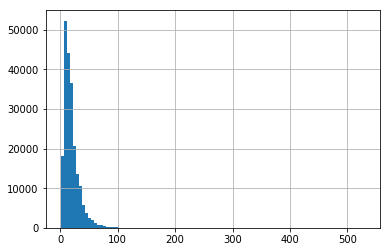

In [214]:
pd.Series(np.array([len(l) for l in data['train']['source']['indices']])).hist(bins=100);

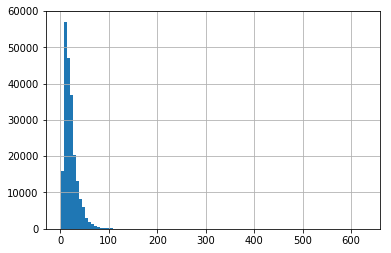

In [215]:
pd.Series(np.array([len(l) for l in data['train']['target']['indices']])).hist(bins=100); 

In [216]:
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
    print(i)
    print(src_idxs.size())
    print(src_idxs)
    print(src_lens)
    break 

0
torch.Size([32, 20])
tensor([[ 3318,  3071,     4,   204,  1606,     3,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 1606,     3,   124,  2128,     3,  4192,     4,  1901,    39,     7,
          1551,     9,   290,   118,  1840,   118, 13834,   198,    23,  3754],
        [ 1606,     3,  1106,     6,     3,     3,     5,     6,  1606,     3,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    7,    52,    84,    67,  1901,  1818,   791,    67,  3318,  3020,
             4,   146,     1,     0,     0,     0,     0,     0,     0,     0],
        [    7,    11,    15,  2319,  2042,     4,  8379,     3,     3,  3089,
             4,  1901,  4470,   928,   195,  1765,   457,     1,     0,     0],
        [ 8379,     3,     3,     3,  3089,  1244,     6,   597,     9,  2319,
         16171,  4237,    36,   142,     3,    16,    71,    55,   144,     3],
        [  282,   470, 

# Model Architecture

In [217]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, pretrained_word2vec):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
#        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
#        embedded = self.embedding(input).view(1, 1, -1)
#        print(input)
#         print(input.size())
        batch_size = input.size()[0]
        embedded = self.embedding(input).view(SRC_MAX_SENTENCE_LEN, batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, pretrained_word2vec):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
#        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding = nn.Embedding.from_pretrained(pretrained_word2vec, freeze=True)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
#         print("Before embedding, targ[i-1] size is: {}".format(input.size()))
#         print("Before embedding, targ[i-1] is: {}".format(input))     
        batch_size = input.size()[0]
        output = self.embedding(input).view(1, batch_size, -1)
#         print("After embedding, targ[i-1] size is: {}".format(output.size()))
#         print("After embedding, targ[i-1] is: {}".format(output))
        output = F.relu(output)
#         print("After embedding, targ[i-1] size is: {}".format(output.size()))
#         print("After embedding, targ[i-1] is: {}".format(output))
#         print("hidden size is: {}".format(hidden.size()))        
#         print("hidden is: {}".format(hidden))        
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))       
#         output = output.squeeze(0) # B x N
#         output = F.log_softmax(self.out(output))
        
        return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)
    
class EncoderDecoder(nn.Module): 
    def __init__(self, encoder, decoder): 
        super(EncoderDecoder, self).__init__() 
        self.encoder = encoder 
        self.decoder = decoder 
        self.output_size = self.decoder.output_size
        
    def forward(self, src, targ): 
        batch_size = src.size()[0]
        encoder_hidden = encoder.initHidden(batch_size)
        encoder_output, encoder_hidden = self.encoder(src, encoder_hidden)
        decoder_hidden = encoder_hidden 
#        print("Encoder Hidden size: {}".format(encoder_hidden.size()))
        final_outputs = Variable(torch.zeros(TARG_MAX_SENTENCE_LEN, batch_size, self.output_size))
        for di in range(1, TARG_MAX_SENTENCE_LEN): 
#            print("targ[di-1] Size is {}".format(targ[:, di-1].size()))
            decoder_outputs, decoder_hidden = self.decoder(targ[:, di-1], decoder_hidden)
#            print("Final Outputs {} is {}".format(di, decoder_outputs))
            top1 = decoder_outputs.data.max(1)[1]
#            print("Top 1 is {}".format(top1))
            final_outputs[di] = decoder_outputs
        return final_outputs

# Train and Evaluate

In [218]:
def evaluate(model, loader): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    
    model.eval() 
    criterion = nn.NLLLoss()
    total_loss = 0 
    
    for src_idxs, targ_idxs, src_lens, targ_lens in loader: 
        input_len = src_idxs.size()[0]
        final_outputs = model(src_idxs, targ_idxs) 
        loss = criterion(final_outputs.view(input_len, TARG_VOCAB_SIZE, TARG_MAX_SENTENCE_LEN), 
                         targ_idxs.view(input_len, TARG_MAX_SENTENCE_LEN))
        total_loss += loss.item()  
    
    return total_loss 

In [219]:
def train(model, train_loader, dev_loader, num_epochs=3, learning_rate=0.1, 
          print_intermediate=True, save_checkpoint=False, model_name='default'): 
    
    # initialize optimizer and criterion 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    results = [] 
    
    # loop through train data in batches and train 
    for epoch in range(num_epochs): 
        train_loss = 0 
        for batch, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            final_outputs = model(src_idxs, targ_idxs) 
            loss = criterion(final_outputs.view(BATCH_SIZE, TARG_VOCAB_SIZE, TARG_MAX_SENTENCE_LEN), 
                             targ_idxs.view(BATCH_SIZE, TARG_MAX_SENTENCE_LEN))
            loss.backward()
            optimizer.step()
            
            if batch % 10 == 0 or ((epoch==num_epochs-1) & (batch==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + batch / len(train_loader)
#                result['train_loss'] = evaluate(model, train_loader) 
                result['val_loss'] = evaluate(model, dev_loader)
                results.append(result)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Validation Loss: {:.2f}'.format(
                        result['epoch'], result['val_loss']))
            
        print("Epoch 1 {}: Total loss is {}".format(i, total_loss))  

In [220]:
encoder = EncoderRNN(input_size=SRC_VOCAB_SIZE, hidden_size=HIDDEN_SIZE, 
                     pretrained_word2vec=get_pretrained_emb(data['train']['source']['word2vec'],
                                                            data['train']['source']['token2id']))
decoder = DecoderRNN(output_size=TARG_VOCAB_SIZE, hidden_size=HIDDEN_SIZE, 
                     pretrained_word2vec=get_pretrained_emb(data['train']['target']['word2vec'], 
                                                            data['train']['target']['token2id']))
model = EncoderDecoder(encoder, decoder)
train(model, train_loader, dev_loader) 

Epoch: 0.00, Validation Loss: 321.06
Epoch: 0.00, Validation Loss: 3449.22
Epoch: 0.00, Validation Loss: 4754.30
Epoch: 0.00, Validation Loss: 5152.16
Epoch: 0.01, Validation Loss: 5994.51
Epoch: 0.01, Validation Loss: 6560.50
Epoch: 0.01, Validation Loss: 6848.36
Epoch: 0.01, Validation Loss: 7395.76
Epoch: 0.01, Validation Loss: 7443.46
Epoch: 0.01, Validation Loss: 7738.49
Epoch: 0.01, Validation Loss: 8047.98
Epoch: 0.02, Validation Loss: 8804.66
Epoch: 0.02, Validation Loss: 9480.60
Epoch: 0.02, Validation Loss: 9895.98
Epoch: 0.02, Validation Loss: 10692.24
Epoch: 0.02, Validation Loss: 10804.84
Epoch: 0.02, Validation Loss: 10953.47
Epoch: 0.03, Validation Loss: 11247.80
Epoch: 0.03, Validation Loss: 11718.22
Epoch: 0.03, Validation Loss: 11982.94
Epoch: 0.03, Validation Loss: 11972.60
Epoch: 0.03, Validation Loss: 12642.39
Epoch: 0.03, Validation Loss: 12731.02
Epoch: 0.03, Validation Loss: 12457.44
Epoch: 0.04, Validation Loss: 12675.03
Epoch: 0.04, Validation Loss: 12837.38
E

KeyboardInterrupt: 

In [ ]:
encoder = EncoderRNN(input_size=SRC_VOCAB_SIZE, hidden_size=10)
decoder = DecoderRNN(output_size=TARG_VOCAB_SIZE, hidden_size=10)
model = EncoderDecoder(encoder, decoder)
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
#     print("Targ shape is {}".format(targ_idxs.size()))
#     print(i)
#     print(src_idxs.size())
#     print(src_idxs)
#     print(src_lens)    
    final_outputs = model(src_idxs, targ_idxs)
    print(final_outputs.size())
    print(final_outputs)
    print(targ_idxs.size())
    break 

In [28]:
# encoder = EncoderRNN(input_size=10000, hidden_size=10)
# decoder = DecoderRNN(hidden_size=10, output_size=10000)
# encoder_hidden = encoder.initHidden()

# for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(train_loader):
#     print(i)
#     print(src_idxs.size())
#     print(src_idxs)
#     print(src_lens)
#     output, hidden = encoder(src_idxs, encoder_hidden)
#     print("Output:::")
#     print(output.size())
#     print(output)
#     print("Hidden:::")
#     print(hidden.size())
#     print(hidden)
#     dec_output, dec_hidden = decoder(targ_idxs, hidden) 
#     print("Decoder Output:::")
#     print(dec_output.size())
#     print(dec_output)    
#     print("Decoder Hidden:::")
#     print(dec_hidden.size())
#     print(dec_hidden)
#     break 